# ARCFace


This is a simply guide that helped me to understand how arcface (https://arxiv.org/abs/1801.07698) and sphere-face (https://arxiv.org/abs/1704.08063) works.

This guide will gently moves from softmax to arcface and sphere face.
To better visualize what's going on MNIST dataset is used and a very simple architecture is used as a backbone.

Have fun!


In [3]:
from functools import partial

# Checking if everything is alright with the GPU
import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["TF_DETERMINISTIC_OPS"] = "1"
#from plot import plot_scatter

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
import numpy as np

def plot_scatter(X, y):

    from sklearn.manifold import TSNE
    X_ = TSNE(n_components=3).fit_transform(X)

    labels = set(y)   
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for label in labels:
        indexes = np.where(y==label)[0]
        scatter = X_[indexes,:]  
        ax.scatter(scatter[:,0], scatter[:,1], scatter[:,2])

    plt.show()  

print(tf.test.gpu_device_name())

/device:GPU:0


In [4]:
# Simple architecture used in our experiments

def backbone(inputs, include_top=False, n_classes=10, training=None):
    tf.random.set_seed(0)

    x = tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", name="conv1")(inputs)
    x = tf.keras.layers.MaxPool2D((2,2), name="maxp1")(x)
    x = tf.keras.layers.BatchNormalization(name="batch_norm1")(x, training=training)
    x = tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu", name="conv2")(x)
    x = tf.keras.layers.MaxPool2D((2,2), name="maxp2")(x)
    x = tf.keras.layers.BatchNormalization(name="batch_norm2")(x, training=training)
    x = tf.keras.layers.Flatten(input_shape=x.shape[1:])(x)
    x = tf.keras.layers.Dense(128, activation='relu', name="fc1")(x)
    x = tf.keras.layers.BatchNormalization(name="batch_norm3")(x, training=training)
    x = tf.keras.layers.Dense(20, activation=None, name="embeddings")(x)
    x = tf.keras.layers.BatchNormalization(name="batch_norm4")(x, training=training)
    x = tf.keras.layers.Dropout(0.2)(x, training=training)
    if include_top:
        x = tf.keras.layers.Dense(n_classes, name="hot", activation=None)(x)
    return x


# From Softmax cross entropy to ArcFace

One of the work horses of Machine Learning is the Softmax + Cross Entropy loss.
The softmax is defined as:


$$\text{soft}(x_i) = \frac{ \text{exp}(Wx_i + b) }{\sum_{j=1}^n \text{exp}(Wx_j + b)}  $$

and the cross entropy loss is defined as:

$$L_1 = -\frac{1}{m}\sum\limits_{i=1}^m y_i \text{log}(\text{soft}(x_i)) $$

Below follow an example using Tensorflow on how to train a CNN using this loss.
What is important in this exercise is to observe the how the embedding space is organized in this 10 class classification problem.

One of the main drawbacks for the cross-entropy loss for face representation is its hability to generate a face space discriminative enough in open set scenarious.
It's possible to have a grasp of this in the t-SNE below where the representation for each one of the 10 classes is less "visual" compact (within class variability) compared with other examples .


Epoch 1/10
938/938 [==============================] - 14s 6ms/step - loss: 1.5506 - accuracy: 0.9371
Epoch 2/10
938/938 [==============================] - 7s 7ms/step - loss: 1.4697 - accuracy: 0.9780
Epoch 3/10
938/938 [==============================] - 7s 7ms/step - loss: 1.4592 - accuracy: 0.9830
Epoch 4/10
938/938 [==============================] - 7s 7ms/step - loss: 1.4564 - accuracy: 0.9851
Epoch 5/10
938/938 [==============================] - 7s 7ms/step - loss: 1.4544 - accuracy: 0.9860
Epoch 6/10
938/938 [==============================] - 6s 7ms/step - loss: 1.4523 - accuracy: 0.9851
Epoch 7/10
938/938 [==============================] - 6s 7ms/step - loss: 1.4517 - accuracy: 0.9848
Epoch 8/10
938/938 [==============================] - 6s 7ms/step - loss: 1.4482 - accuracy: 0.9865
Epoch 9/10
938/938 [==============================] - 6s 7ms/step - loss: 1.4478 - accuracy: 0.9867
Epoch 10/10
938/938 [==============================] - 6s 7ms/step - loss: 1.4474 - accuracy: 0.988

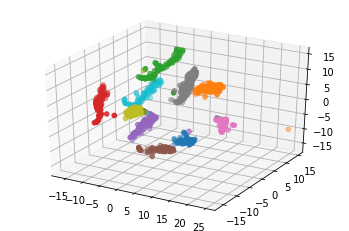

In [5]:
import tensorflow as tf
import numpy as np

# Loading MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

train_dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
train_dataset = train_dataset.batch(64)

def softmax_cross_entropy(target, output, sparse=True, n_classes=10):
    
    target = tf.squeeze(target)
    
    ## SIMPLIFIED
    
    logits_max = tf.math.reduce_max(output, axis=-1, keepdims=True)
    N = logits_max.shape[0]
    shifted_logits = output - logits_max
    exp_shifted_logits = tf.math.exp(shifted_logits)
    
    if sparse:
        y = tf.one_hot(tf.cast(target,"int32"), depth=n_classes)
    else:
        y = target
        
    sum_exp = tf.math.reduce_sum(exp_shifted_logits,axis=-1, keepdims=True)
    log_sum_exp = tf.math.log(sum_exp)
    
    sub = shifted_logits - log_sum_exp
    mul = tf.math.multiply(tf.math.negative(y), sub)
    #L = tf.math.reduce_sum(mul)/N
    L = tf.math.reduce_mean(tf.math.reduce_sum(mul, axis=-1))

    return L


tf.random.set_seed(0)

inputs = tf.keras.layers.Input([28, 28, 1], name="Input")
logits = tf.nn.l2_normalize(backbone(inputs, include_top=True),axis=1)
model = tf.keras.Model(inputs=inputs, outputs=logits)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.Adam(learning_rate=0.01)


model.compile(optimizer=optimizer,
              loss=softmax_cross_entropy,
              metrics=['accuracy'])

#print(model.summary())

model.fit(train_dataset, epochs=10, steps_per_epoch=None)


predict_model = tf.keras.Model(inputs=inputs, outputs=model.get_layer("embeddings").output)
embeddings = tf.nn.l2_normalize(predict_model.predict(x_test[0:1000]),axis=1)
plot_scatter(embeddings, y_test[0:1000])


# Angular Boundaries

## Modified Softmax from the paper Sphere-Face

$$\text{soft}(x_i) = \frac{exp(||x_i||\text{cos}(\theta_{yi}))}{\sum_j  exp(||x_i||\text{cos}(\theta_{j}))   }$$, where $cos(\theta_i)=W_i^{\intercal}x_i$

Below follow the same example as aforementioned, but using the modified softmax.




/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


938/938 [==============================] - 8s 7ms/step - loss: 0.4602 - accuracy: 0.9380
Epoch 1/9
938/938 [==============================] - 8s 7ms/step - loss: 0.1360 - accuracy: 0.9638
Epoch 2/9
938/938 [==============================] - 7s 7ms/step - loss: 0.0483 - accuracy: 0.9880
Epoch 3/9
938/938 [==============================] - 6s 7ms/step - loss: 0.0373 - accuracy: 0.9913
Epoch 4/9
938/938 [==============================] - 6s 7ms/step - loss: 0.0303 - accuracy: 0.9924
Epoch 5/9
938/938 [==============================] - 7s 7ms/step - loss: 0.0269 - accuracy: 0.9939
Epoch 6/9
938/938 [==============================] - 6s 7ms/step - loss: 0.0218 - accuracy: 0.9954
Epoch 7/9
938/938 [==============================] - 6s 7ms/step - loss: 0.0184 - accuracy: 0.9970
Epoch 8/9
938/938 [==============================] - 7s 7ms/step - loss: 0.0184 - accuracy: 0.9964
Epoch 9/9
938/938 [==============================] - 6s 7ms/step - loss: 0.0172 - accuracy: 0.9972


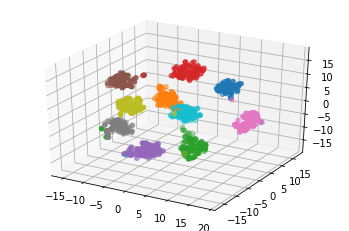

In [6]:
import tensorflow as tf
import math
import numpy as np

class ModifiedSoftMaxHead(tf.keras.layers.Layer):

    def __init__(self, n_classes=10):
        super(ModifiedSoftMaxHead, self).__init__(name ="modified_softmax_logits")
        self.n_classes = n_classes

        
    def build(self, input_shape):
        super(ModifiedSoftMaxHead, self).build(input_shape[0])
        shape = [input_shape[-1], self.n_classes]
        
        self.W = self.add_variable("W", shape=shape)
        

    def call(self, X, training=None):
        
        # normalize feature
        W = tf.nn.l2_normalize(self.W, axis=0)

        # cos between X and W            
        cos_yi = tf.nn.l2_normalize(X, axis=1) @ W
                
        logits = tf.norm(X)*cos_yi
        
        return logits
    
        
tf.random.set_seed(0)

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

train_dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
train_dataset = train_dataset.batch(64)


# PRE MODEL WITH CROSS ENTROPY
n_classes = 10
inputs = tf.keras.layers.Input([28, 28, 1], name="input")
labels = tf.keras.layers.Input([], name="label")

embeddings = tf.nn.l2_normalize(backbone(inputs, include_top=False),axis=1)
logits_cross_entropy = tf.keras.layers.Dense(n_classes, name="hot", activation=None)(embeddings)
pre_model = tf.keras.Model(inputs=inputs, outputs=logits_cross_entropy)

#### NOW THE MODIFIED CROSS ENTROPY

logits_modsoft = ModifiedSoftMaxHead()(embeddings)

modsoft_model = tf.keras.Model(inputs, outputs=logits_modsoft)
#print(arcface_model.summary())

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.Adam(learning_rate=0.01)


# First do cross entropy
pre_model.compile(optimizer=optimizer,
              loss=softmax_cross_entropy,
              metrics=['accuracy'])
pre_model.fit(train_dataset, epochs=1)


# second do arcface 
modsoft_model.compile(optimizer=optimizer,
              loss=softmax_cross_entropy,
              metrics=['accuracy'])
modsoft_model.fit(train_dataset, epochs=9)


predict_model = tf.keras.Model(inputs=inputs, outputs=modsoft_model.get_layer("embeddings").output)
embeddings = tf.nn.l2_normalize(predict_model.predict(x_test[0:1000]), axis=1)
plot_scatter(embeddings, y_test[0:1000])

# Sphere Face

$$\text{soft}(x_i) = \frac{exp(||x_i||\text{cos}(\psi(\theta_{yi})))}{exp(||x_i||\text{cos}(\psi(\theta_{yi}))) + \sum_{j;j\neq yi}  exp(||x_i||\text{cos}(\psi(\theta_{j})))   }$$,

where, $\psi(\theta) = -1^k \text{cos}(m\theta)-2k$.

In this case, $theta \in [\frac{k\pi}{m} , \frac{(k+1)\pi}{m}]$  $k \in [0, m-1]$

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


938/938 [==============================] - 6s 6ms/step - loss: 0.4609 - accuracy: 0.9377
Epoch 1/9
938/938 [==============================] - 6s 6ms/step - loss: 0.0630 - accuracy: 0.9832
Epoch 2/9
938/938 [==============================] - 5s 6ms/step - loss: 0.0449 - accuracy: 0.9882
Epoch 3/9
938/938 [==============================] - 6s 6ms/step - loss: 0.0353 - accuracy: 0.9895
Epoch 4/9
938/938 [==============================] - 6s 6ms/step - loss: 0.0286 - accuracy: 0.9917
Epoch 5/9
938/938 [==============================] - 6s 6ms/step - loss: 0.0221 - accuracy: 0.9937
Epoch 6/9
938/938 [==============================] - 6s 6ms/step - loss: 0.0208 - accuracy: 0.9937
Epoch 7/9
938/938 [==============================] - 6s 6ms/step - loss: 0.0149 - accuracy: 0.9952
Epoch 8/9
938/938 [==============================] - 6s 6ms/step - loss: 0.0123 - accuracy: 0.9964
Epoch 9/9
938/938 [==============================] - 5s 6ms/step - loss: 0.0136 - accuracy: 0.9959


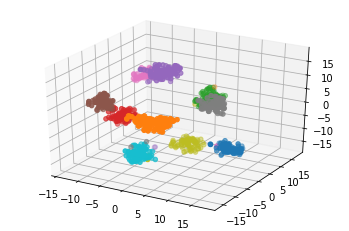

In [7]:
import tensorflow as tf
import math
import numpy as np


# HYPERPARAMETERS

M = 5.
n_classes = 10

     
class SphereFaceLayer(tf.keras.layers.Layer):
    def __init__(self, n_classes=10, m=0.5):
        super(SphereFaceLayer, self).__init__(name ="sphere_face_logits")
        self.n_classes = n_classes
        self.m = m

        
    def build(self, input_shape):
        super(SphereFaceLayer, self).build(input_shape[0])
        shape = [input_shape[-1], self.n_classes]
        
        self.W = self.add_variable("W", shape=shape)
        self.pi = tf.constant(math.pi)
                
    
    def call(self, X, training=None):
        
        # normalize feature
        X = tf.nn.l2_normalize(X, axis=1)
        W = tf.nn.l2_normalize(self.W, axis=0)

        # cos between X and W            
        cos_yi = tf.matmul(X, W)

        
        # cos(m \theta)
        theta = tf.math.acos(cos_yi)    
        cos_theta_m = tf.math.cos(self.m*theta)

        # ||x||
        x_norm = tf.norm(X, axis=-1, keepdims=True)
        
        # phi = -1**k * cos(m \theta) - 2k
        k = self.m * (theta / self.pi)        
        phi = ((-1**k)* cos_theta_m) - 2*k
        
        logits = x_norm*phi
        
            
        return logits     

    


tf.random.set_seed(0)

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

train_dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
train_dataset = train_dataset.batch(64)
tf.random.set_seed(0)

# PRE MODEL WITH CROSS ENTROPY
inputs = tf.keras.layers.Input([28, 28, 1], name="input")
labels = tf.keras.layers.Input([], name="label")

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.Adam(learning_rate=0.01)


# Creating PRE MODEL
embeddings = tf.nn.l2_normalize(backbone(inputs, include_top=False), axis=1)
logits_cross_entropy = tf.keras.layers.Dense(n_classes, name="hot", activation=None)(embeddings)
pre_model = tf.keras.Model(inputs=inputs, outputs=logits_cross_entropy)

# Arcface model
logits_sphereface = SphereFaceLayer(m=M)(embeddings)
sphereface_model = tf.keras.Model(inputs=inputs, outputs=logits_cross_entropy)


#print(pre_model.summary())

pre_model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])
pre_model.fit(train_dataset, epochs=1)



# second do arcface
#
sphereface_model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])
sphereface_model.fit(train_dataset, epochs=9)



predict_model = tf.keras.Model(inputs=inputs, outputs=sphereface_model.get_layer("embeddings").output)
embeddings = tf.nn.l2_normalize(predict_model.predict(x_test[0:1000]), axis=1)
plot_scatter(embeddings, y_test[0:1000])




## ArcFace
Essentially, in ArcFace, the logit is transform as follows $W^{\intercal}x_i = ||W|| ||x_i|| cos(\theta)$ where $\theta$ is the angle between the weight $W$ and the feture $x_i$.
Then basically the softmax-cors is replaced by:


$$\text{arc}(x_i) = \frac{\text{exp}(s(cos(\theta_i) + m))}{\text{exp}(s(cos(\theta_i) + m)) + \sum\limits_{j=1;j\neq i}^{m} \text{exp}(s(cos(\theta_j) + m))} $$,
where $s$ is a scaling factor and $m$ is a margin penalty.

Below follow the same example as aforementioned, but using the center loss.
It's possible to observe from the t-SNE below that the representation for each one of the 10 classes is more "visual" compact (within class variability) compared with the cross-entropy example.

> **This is what I understood from equation (3). It's tricky make a good descend on this.**:


This implementation is based on:

https://github.com/ronghuaiyang/arcface-pytorch/blob/master/models/metrics.py

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


938/938 [==============================] - 6s 6ms/step - loss: 0.4609 - accuracy: 0.9377
Epoch 1/9
938/938 [==============================] - 7s 6ms/step - loss: 0.6996 - accuracy: 0.9197
Epoch 2/9
938/938 [==============================] - 6s 6ms/step - loss: 0.1865 - accuracy: 0.9745
Epoch 3/9
938/938 [==============================] - 6s 6ms/step - loss: 0.1403 - accuracy: 0.9793
Epoch 4/9
938/938 [==============================] - 6s 7ms/step - loss: 0.1000 - accuracy: 0.9848
Epoch 5/9
938/938 [==============================] - 7s 7ms/step - loss: 0.0862 - accuracy: 0.9853
Epoch 6/9
938/938 [==============================] - 6s 7ms/step - loss: 0.0673 - accuracy: 0.9884
Epoch 7/9
938/938 [==============================] - 7s 7ms/step - loss: 0.0610 - accuracy: 0.9888
Epoch 8/9
938/938 [==============================] - 7s 7ms/step - loss: 0.0539 - accuracy: 0.9903
Epoch 9/9
938/938 [==============================] - 7s 7ms/step - loss: 0.0435 - accuracy: 0.9917


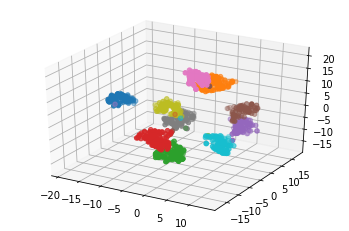

In [8]:
import tensorflow as tf
import math
import numpy as np
from functools import partial

# ARCFACE HYPER PARAMETERS
S = 30.
M = 0.2
n_classes = 10


class ArcFaceModel(tf.keras.Model):

    def train_step(self, data):
        X, y = data
        with tf.GradientTape() as tape:

            logits = self((X,y), training=True)
            loss = self.compiled_loss(
                  y, logits, sample_weight=None, regularization_losses=self.losses)
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)            
                   
        self.compiled_metrics.update_state(y, logits, sample_weight=None)
        return {m.name: m.result() for m in self.metrics}   


class ArcFaceLayer(tf.keras.layers.Layer):
    def __init__(self, n_classes=10, s=30, m=0.5):
        super(ArcFaceLayer, self).__init__(name ="arc_face_logits")
        self.n_classes = n_classes
        self.s = s
        self.m = m

        
    def build(self, input_shape):
        super(ArcFaceLayer, self).build(input_shape[0])
        shape = [input_shape[-1], self.n_classes]
        
        self.W = self.add_variable("W", shape=shape)

        self.cos_m = tf.identity(math.cos(self.m), name='cos_m')
        self.sin_m = tf.identity(math.sin(self.m), name='sin_m')
        self.th = tf.identity(math.cos(math.pi - self.m), name='th')
        self.mm = tf.identity(math.sin(math.pi - self.m)*self.m)
        
        
    
    def call(self, X, y, training=None):
        
        # normalize feature
        X = tf.nn.l2_normalize(X, axis=1)
        W = tf.nn.l2_normalize(self.W, axis=0)

        # cos between X and W            
        cos_yi = tf.matmul(X, W)

        #sin_yi = tf.math.sqrt(1-cos_yi**2)
        sin_yi = tf.clip_by_value(tf.math.sqrt(1-cos_yi**2), 0,1)

        # cos(x+m) = cos(x)*cos(m) - sin(x)*sin(m)
        cos_yi_m = cos_yi*self.cos_m - sin_yi*self.sin_m
        
        
        cos_yi_m = tf.where(cos_yi > self.th, cos_yi_m, cos_yi - self.mm)
        
        
        # Preparing the hot-output
        one_hot = tf.one_hot(tf.cast(y, tf.int32), depth=self.n_classes,
                          name='one_hot_mask')
       

        logits = (one_hot * cos_yi_m) + ((1.0 - one_hot) * cos_yi)
    
        #logits = tf.where(mask == 1., cos_yi_m, cos_yi)
        logits = self.s*logits
        
        return logits        


(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

train_dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
train_dataset = train_dataset.batch(64)
tf.random.set_seed(0)

# PRE MODEL WITH CROSS ENTROPYn_classes = 10
inputs = tf.keras.layers.Input([28, 28, 1], name="input")
labels = tf.keras.layers.Input([], name="label")

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.Adam(learning_rate=0.01)


# Creating PRE MODEL
embeddings = tf.nn.l2_normalize(backbone(inputs, include_top=False), axis=1)
logits_cross_entropy = tf.keras.layers.Dense(n_classes, name="hot", activation=None)(embeddings)
pre_model = tf.keras.Model(inputs=inputs, outputs=logits_cross_entropy)

# Arcface model
logits_arcface = ArcFaceLayer(s=S,m=M)(embeddings, labels)
arcface_model = ArcFaceModel(inputs=(inputs,labels), outputs=logits_arcface)


#print(pre_model.summary())

pre_model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])
pre_model.fit(train_dataset, epochs=1)



# second do arcface
#
arcface_model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])
arcface_model.fit(train_dataset, epochs=9)

#arcface_model.fit([x_train, y_train],y_train, epochs=20)



predict_model = tf.keras.Model(inputs=inputs, outputs=arcface_model.get_layer("embeddings").output)
embeddings = tf.nn.l2_normalize(predict_model.predict(x_test[0:1000]), axis=1)
plot_scatter(embeddings, y_test[0:1000])



## ArcFace + Sphere Face + CosFace

$$L = -\frac{1}{N} \sum\limits_{i=1}^{M} \text{log} \frac{\text{exp}(s(cos(m_1\theta_i + m_2) -m_3))}{\text{exp}(s(cos(m_1\theta_i + m_2) -m_3)) + \sum\limits_{j=1;j\neq i}^{m} \text{exp}(s(cos(\theta_j)))} $$

The cos-face boundaries can be achieved with $m_2$.

According to the arcface paper, sphere face can be achieved if $m_2=0$ and $m_3=0$

In [1]:
import tensorflow as tf
import math
import numpy as np
from functools import partial

# ARCFACE HYPER PARAMETERS
S = 30.
M1 = 1.
M2 = 0.5
M3 = 0


class ArcFaceLayer3Penalties(tf.keras.layers.Layer):
    def __init__(self, n_classes=10, s=30, m1=0.5, m2=0.5, m3=0.5):
        super(ArcFaceLayer3Penalties, self).__init__(name ="arc_face_logits")
        self.n_classes = n_classes
        self.s = s
        self.m1 = m1
        self.m2 = m2
        self.m3 = m3        

        
    def build(self, input_shape):
        super(ArcFaceLayer3Penalties, self).build(input_shape[0])
        shape = [input_shape[-1], self.n_classes]
        
        self.W = self.add_variable("W", shape=shape)

        
    
    def call(self, X, y, training=None):
        
        # normalize feature
        X = tf.nn.l2_normalize(X, axis=1)
        W = tf.nn.l2_normalize(self.W, axis=0)

        # cos between X and W            
        cos_yi = tf.matmul(X, W)

        
        # Getting the angle
        theta = tf.math.acos(cos_yi)
            
        cos_yi_m = tf.math.cos(self.m1*theta+self.m2)-self.m3
        
        #logits = self.s*cos_theta_m
        
        # Preparing the hot-output
        one_hot = tf.one_hot(tf.cast(y, tf.int32), depth=self.n_classes,
                          name='one_hot_mask')
       

        logits = (one_hot * cos_yi_m) + ((1.0 - one_hot) * cos_yi)
    
        logits = self.s*logits
        
        return logits        

        

    

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

train_dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
train_dataset = train_dataset.batch(64)
tf.random.set_seed(0)

# PRE MODEL WITH CROSS ENTROPYn_classes = 10
inputs = tf.keras.layers.Input([28, 28, 1], name="input")
labels = tf.keras.layers.Input([], name="label")

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.Adam(learning_rate=0.01)


# Creating PRE MODEL
embeddings = tf.nn.l2_normalize(backbone(inputs, include_top=False), axis=1)
logits_cross_entropy = tf.keras.layers.Dense(n_classes, name="hot", activation=None)(embeddings)
pre_model = tf.keras.Model(inputs=inputs, outputs=logits_cross_entropy)

# Arcface model
logits_arcface3p = ArcFaceLayer3Penalties(s=S,m1=M1, m2=M2, m3=M3)(embeddings, labels)
arcface3p_model = ArcFaceModel(inputs=(inputs,labels), outputs=logits_arcface3p)


#print(pre_model.summary())

pre_model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])
pre_model.fit(train_dataset, epochs=1)



# second do arcface
#
arcface3p_model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])
arcface3p_model.fit(train_dataset, epochs=9)

#arcface_model.fit([x_train, y_train],y_train, epochs=20)



predict_model = tf.keras.Model(inputs=inputs, outputs=arcface3p_model.get_layer("embeddings").output)
embeddings = tf.nn.l2_normalize(predict_model.predict(x_test[0:1000]), axis=1)
plot_scatter(embeddings, y_test[0:1000])

NameError: name 'backbone' is not defined